# Semantic Segmentation using Unet from scratch and pre-trained models

In this work I am going to do semantic segmentation by using the [**Cityscapes**](http://www.cityscapes-dataset.com/) dataset. I used the following two techniques to achieve this. 
1. **Own Model:** In the first technique I am designing the Unet architecture and training it from the scratch using the given data
2. **Pre-trained Models:** In the second technique, I am going to use the pre-trained models such as Unet,DeepLabV3+, SegNet, and VGG

# 0: Loading and preprocessing the dataset

Regardless of the method being used, first, we need to load the dataset and perform the necessary preprocessing in order to make it prepare for training.

In [3]:
import tensorflow as tf
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
img = glob.glob('../input/cityscapes/Cityspaces/images/train/*/*.png') # tf.io.glob.glob
label = glob.glob('../input/cityscapes/Cityspaces/gtFine/train/*/*_gtFine_labelIds.png')
img_names = [path.split('/train/')[1].split('_leftImg8bit.png')[0] for path in img]
label = ['../input/cityscapes/Cityspaces/gtFine/train/' + name + '_gtFine_labelIds.png' for name in img_names]

len(img)

2975

In [5]:
index = np.random.permutation(2975)
img = np.array(img)[index]
label = np.array(label)[index]

img[:5], label[:5]

(array(['../input/cityscapes/Cityspaces/images/train/monchengladbach/monchengladbach_000000_034621_leftImg8bit.png',
        '../input/cityscapes/Cityspaces/images/train/dusseldorf/dusseldorf_000065_000019_leftImg8bit.png',
        '../input/cityscapes/Cityspaces/images/train/hamburg/hamburg_000000_011641_leftImg8bit.png',
        '../input/cityscapes/Cityspaces/images/train/darmstadt/darmstadt_000029_000019_leftImg8bit.png',
        '../input/cityscapes/Cityspaces/images/train/zurich/zurich_000048_000019_leftImg8bit.png'],
       dtype='<U105'),
 array(['../input/cityscapes/Cityspaces/gtFine/train/monchengladbach/monchengladbach_000000_034621_gtFine_labelIds.png',
        '../input/cityscapes/Cityspaces/gtFine/train/dusseldorf/dusseldorf_000065_000019_gtFine_labelIds.png',
        '../input/cityscapes/Cityspaces/gtFine/train/hamburg/hamburg_000000_011641_gtFine_labelIds.png',
        '../input/cityscapes/Cityspaces/gtFine/train/darmstadt/darmstadt_000029_000019_gtFine_labelIds.png',
 

In [6]:
val_img = glob.glob('../input/cityscapes/Cityspaces/images/val/*/*.png') # tf.io.glob.glob
val_label = glob.glob('../input/cityscapes/Cityspaces/gtFine/val/*/*_gtFine_labelIds.png')
img_names = [path.split('/val/')[1].split('_leftImg8bit.png')[0] for path in val_img]
val_label = ['../input/cityscapes/Cityspaces/gtFine/val/' + name + '_gtFine_labelIds.png' for name in img_names]

len(val_img), len(val_label)

(500, 500)

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((img, label))
val_ds = tf.data.Dataset.from_tensor_slices((val_img, val_label))

In [9]:
def read_png(img):
    img = tf.io.read_file(img)
    img = tf.image.decode_png(img, channels=3)
    return img
    
def read_png_label(img):
    img = tf.io.read_file(img)
    img = tf.image.decode_png(img, channels=1)
    return img

In [10]:
def rand_crop(img, label):
    concat_img = tf.concat([img, label], axis=-1)
    concat_img = tf.image.resize(concat_img, [280, 560], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    crop_img = tf.image.random_crop(concat_img, [256, 256, 4])
    return crop_img[:, :, :3], crop_img[:, :, 3:]

def norm(img, label):
    img = tf.cast(img, tf.float32)/127.5-1
    label = tf.cast(label, tf.int32)
    return img, label

In [11]:
def load_img_train(img, label):
    img = read_png(img)
    label = read_png_label(label)
    
    img, label = rand_crop(img, label)
    
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        label = tf.image.flip_left_right(label)
    return norm(img, label)

def load_img_val(img, label):
    img = read_png(img)
    label = read_png_label(label)
    
    img = tf.image.resize(img, [256, 256])
    label = tf.image.resize(label, [256, 256])
    return norm(img, label)

In [12]:
BATCH_SIZE = 16
BUFFER_SIZE = 300
steps_per_epoch = 2975 // BATCH_SIZE
validation_steps = 500 // BATCH_SIZE
auto = tf.data.experimental.AUTOTUNE

train_ds = train_ds.map(load_img_train, num_parallel_calls=auto)
val_ds = val_ds.map(load_img_val, num_parallel_calls=auto)

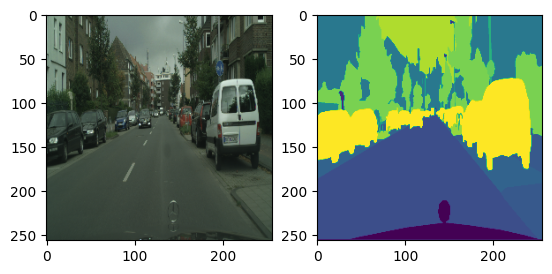

In [13]:
# This figure shows the mask but the original color of the mask is changed due because here we use the default plt.imshow() colormap
for img, label in val_ds.take(1):
    plt.subplot(1, 2, 1)
    plt.imshow((img + 1)/2)
    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(label))

In [14]:
train_ds = train_ds.cache().repeat().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(auto)
val_ds = val_ds.cache().batch(BATCH_SIZE)

# 1. Building and Training Unet from scratch

In [ ]:
def create_model():
    inputs = tf.keras.layers.Input(shape=(256, 256, 3))

    # Encoder part
    
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x) # 256*256*64
    
    x1 = tf.keras.layers.MaxPooling2D(padding='same')(x) # 128*128*64
    
    x1 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)  # 128*128*128
    
    x2 = tf.keras.layers.MaxPooling2D(padding='same')(x1) # 64*64*128
    
    x2 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)  # 64*64*256
    
    x3 = tf.keras.layers.MaxPooling2D(padding='same')(x2) # 32*32*256
    
    x3 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x3)
    x3 = tf.keras.layers.BatchNormalization()(x3)
    x3 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x3)
    x3 = tf.keras.layers.BatchNormalization()(x3)  # 32*32*512
    
    x4 = tf.keras.layers.MaxPooling2D(padding='same')(x3) # 16*16*512
    
    x4 = tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu')(x4)
    x4 = tf.keras.layers.BatchNormalization()(x4)
    x4 = tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu')(x4)
    x4 = tf.keras.layers.BatchNormalization()(x4)  # 16*16*1024

    # Decoder part
    
    x5 = tf.keras.layers.Conv2DTranspose(512, 2, strides=2, padding='same', activation='relu')(x4)
    x5 = tf.keras.layers.BatchNormalization()(x5)  # 32*32*512
    
    x6 = x6 = tf.keras.layers.Concatenate(axis=-1)([x3, x5]) # 32*32*1024
    
    x6 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x6)
    x6 = tf.keras.layers.BatchNormalization()(x6)
    x6 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x6)
    x6 = tf.keras.layers.BatchNormalization()(x6)  # 32*32*512
    
    x7 = tf.keras.layers.Conv2DTranspose(256, 2, strides=2, padding='same', activation='relu')(x6)
    x7 = tf.keras.layers.BatchNormalization()(x7)  # 64*64*256

    x8 = tf.keras.layers.Concatenate(axis=-1)([x2, x7]) # 64*64*512
    
    x8 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x8)
    x8 = tf.keras.layers.BatchNormalization()(x8)
    x8 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x8)
    x8 = tf.keras.layers.BatchNormalization()(x8)  # 64*64*256
    
    x9 = tf.keras.layers.Conv2DTranspose(128, 2, strides=2, padding='same', activation='relu')(x8)
    x9 = tf.keras.layers.BatchNormalization()(x9)  # 128*128*128
    
    x10 = tf.keras.layers.Concatenate(axis=-1)([x1, x9]) # 128*128*256
    
    x10 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x10)
    x10 = tf.keras.layers.BatchNormalization()(x10)
    x10 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x10)
    x10 = tf.keras.layers.BatchNormalization()(x10)  # 128*128*128
    
    x11 = tf.keras.layers.Conv2DTranspose(64, 2, strides=2, padding='same', activation='relu')(x10)
    x11 = tf.keras.layers.BatchNormalization()(x11)  # 256*256*64
    
    x12= tf.keras.layers.Concatenate(axis=-1)([x, x11])# 256*256*128
    
    x12 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x12)
    x12 = tf.keras.layers.BatchNormalization()(x12)
    x12 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x12)
    x12 = tf.keras.layers.BatchNormalization()(x12)  # 256*256*64
    
    outputs = tf.keras.layers.Conv2D(34, 1, activation='softmax')(x12) # 256*256*34
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [13]:
model = create_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[

 Total params: 31,061,282 (118.49 MB)

 Trainable params: 31,047,586 (118.44 MB)

 Non-trainable params: 13,696 (53.50 KB)

In [14]:
# tf.keras.metrics.MeanIoU(num_classes=34) <- One-Hot Coding

class MeanIoU(tf.keras.metrics.MeanIoU):
    def __call__(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().__call__(y_true, y_pred, sample_weight=sample_weight)

In [15]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['acc'])

In [16]:
history = model.fit(train_ds, steps_per_epoch=steps_per_epoch, validation_data=val_ds, validation_steps=validation_steps, epochs=50)

Epoch 1/50


I0000 00:00:1734332016.957242      88 service.cc:145] XLA service 0x7dae8c002540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734332016.957312      88 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1734332018.626624      88 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1734332081.756433      88 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.6012 - loss: 1.7419

W0000 00:00:1734332202.988760      86 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


92/92 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - acc: 0.6022 - loss: 1.7365 - val_acc: 0.2170 - val_loss: 5.6471
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - acc: 0.7690 - loss: 0.8607

W0000 00:00:1734332281.572695      87 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


92/92 ━━━━━━━━━━━━━━━━━━━━ 81s 888ms/step - acc: 0.7691 - loss: 0.8602 - val_acc: 0.3630 - val_loss: 3.5383
Epoch 3/50


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


92/92 ━━━━━━━━━━━━━━━━━━━━ 68s 734ms/step - acc: 0.8027 - loss: 0.7205 - val_acc: 0.3517 - val_loss: 2.7600
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 64s 698ms/step - acc: 0.8156 - loss: 0.6707 - val_acc: 0.2592 - val_loss: 4.1940
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 67s 734ms/step - acc: 0.8283 - loss: 0.6244 - val_acc: 0.4979 - val_loss: 2.4076
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 64s 698ms/step - acc: 0.8358 - loss: 0.5933 - val_acc: 0.5889 - val_loss: 1.7087
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 67s 734ms/step - acc: 0.8487 - loss: 0.5444 - val_acc: 0.7166 - val_loss: 1.1661
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 64s 698ms/step - acc: 0.8517 - loss: 0.5295 - val_acc: 0.7244 - val_loss: 1.0393
Epoch 9/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 68s 734ms/step - acc: 0.8575 - loss: 0.5049 - val_acc: 0.7860 - val_loss: 0.8466
Epoch 10/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 64s 698ms/step - acc: 0.8626 - loss: 0.4869 - val_acc: 0.7187 - val_loss: 1.1337
Epoch 11/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 68s 734ms/step - ac

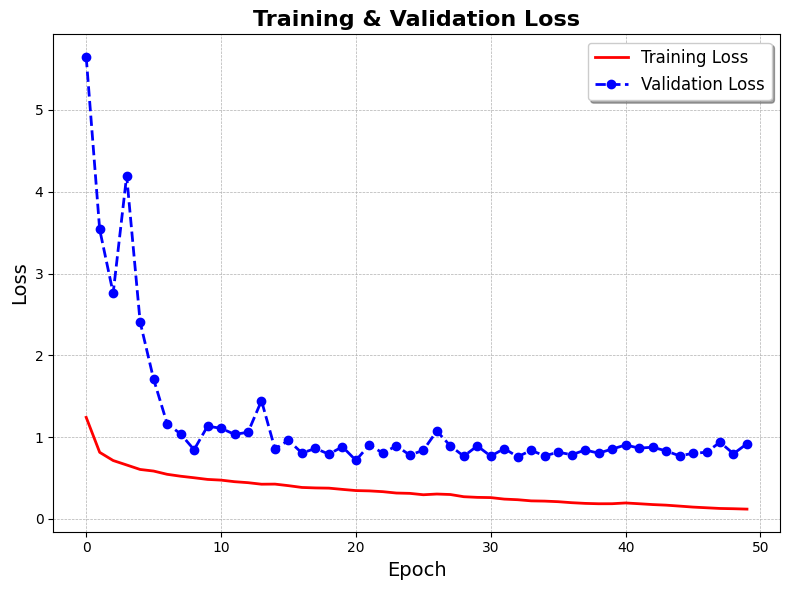

In [57]:
import matplotlib.pyplot as plt

# Assuming loss and val_loss are defined as per your existing code
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 6))  # Set a larger figure size for better readability
plt.plot(range(50), loss, 'r-', linewidth=2, label='Training Loss')  # Red solid line with thickness
plt.plot(range(50), val_loss, 'b--', linewidth=2, marker='o', markersize=6, label='Validation Loss')  # Blue dashed line with markers

# Add titles and labels
plt.title('Training & Validation Loss', fontsize=16, fontweight='bold')  # Bold title with larger font
plt.xlabel('Epoch', fontsize=14)  # Larger x-axis label
plt.ylabel('Loss', fontsize=14)  # Larger y-axis label

# Enhance grid lines for better clarity
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adding a legend with a shadow for better visibility
plt.legend(fontsize=12, loc='upper right', shadow=True)

# Show the plot
plt.tight_layout()  # Ensures that everything fits in the figure area
plt.savefig("/kaggle/working/loss.png", bbox_inches="tight", dpi=300)
plt.show()


In [ ]:
model.save('/kaggle/working/unet.h5')  # Saves in a single HDF5 file

In [15]:
#loading the trained model for inferences
from tensorflow.keras.models import load_model
model = load_model("/kaggle/input/unet/keras/default/1/unet.h5")
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[

 Total params: 31,061,284 (118.49 MB)

 Trainable params: 31,047,586 (118.44 MB)

 Non-trainable params: 13,696 (53.50 KB)

 Optimizer params: 2 (12.00 B)

In [16]:
!pip install cityscapesscripts

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.6/473.6 kB 11.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.1 MB/s eta 0:00:00
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26306 sha256=6d9fcc909c9a12fa7a5378e763e91a44b3c2d9073ceb768d9250843210253cbd
  Stored in directory: /root/.cache/pip/wheels/7c/d0/9e/1f26ebb66d9e1732e4098bc5a6c2d91f6c9a529838f0284890
Successfully built typing


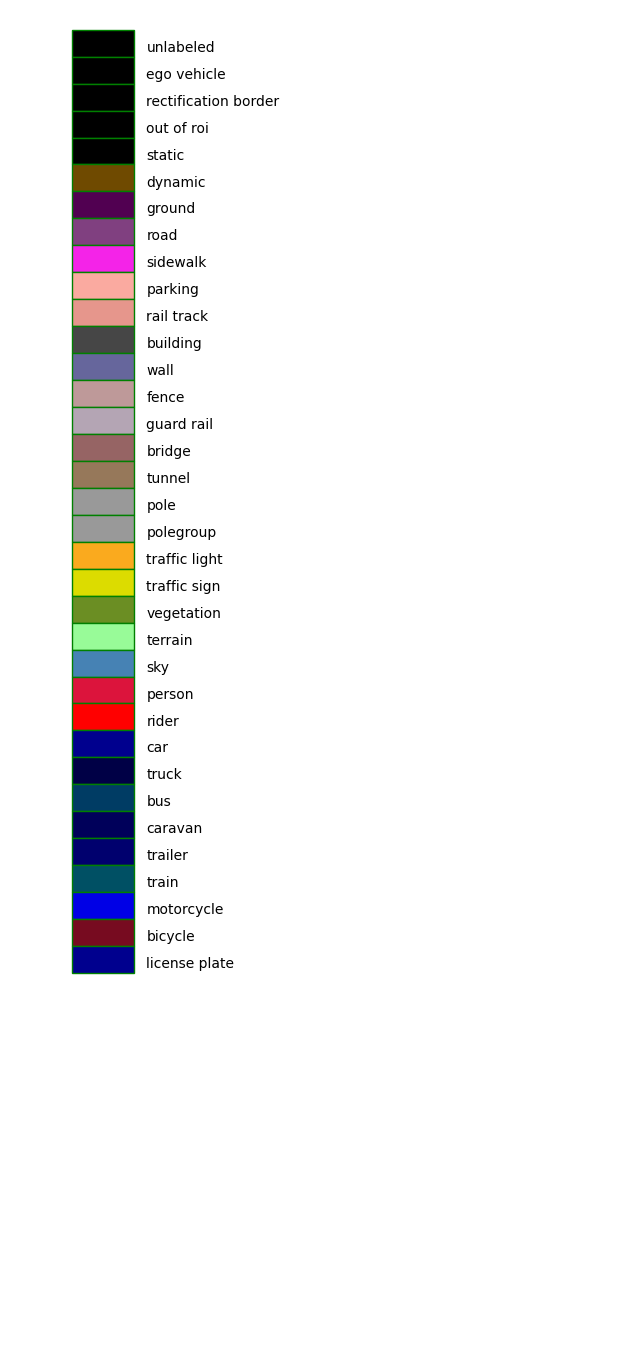

In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from cityscapesscripts.helpers.labels import labels

# Function to display labels with color boxes
def display_labels_with_colors(labels):
    fig, ax = plt.subplots(figsize=(8, len(labels) * 0.5))  # Adjust the figure size
    ax.axis('off')  # Turn off the axis

    # Add each label
    for i, label in enumerate(labels):
        y = 1 - (i + 1) * 0.02  # Calculate vertical position
        
        name = label.name
        id_ = label.id
        train_id = label.trainId
        color = label.color

        # Normalize color values to range [0, 1]
        normalized_color = [c / 255 for c in color]

        # Display color box
        rect_height = 0.02  # Height of the color box
        rect_y_position = y - 0.015  # Slightly above the current label's y position

        # Display color box
        rect = patches.Rectangle((0.1, rect_y_position), 0.1, rect_height, linewidth=1,
                                 edgecolor='green', facecolor=normalized_color)
        ax.add_patch(rect)

        # Display text information
        plt.text(0.22, y-0.011, name, fontsize=10)

    plt.savefig("/kaggle/working/pixelname.png", bbox_inches="tight", dpi=300)

    plt.show()

# Call the function with the Cityscapes labels
display_labels_with_colors(labels)


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from cityscapesscripts.helpers.labels import labels  # Import labels for Cityscapes

# Create a dictionary mapping label ID to its corresponding RGB color from `labels`
label_colors = {label.id: label.color for label in labels}

def apply_color_map(label_image):
    """Map the label image (which contains class IDs) to RGB colors using the label_colors map."""
    # Ensure label_image is 2D (height, width)
    label_image = label_image.squeeze()  # Remove any extra dimensions (e.g., the last one)
    
    # Create a blank RGB image
    color_image = np.zeros((label_image.shape[0], label_image.shape[1], 3), dtype=np.uint8)
    
    # Iterate over each label ID and apply its color
    for label_id, color in label_colors.items():
        color_image[label_image == label_id] = color
    
    return color_image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


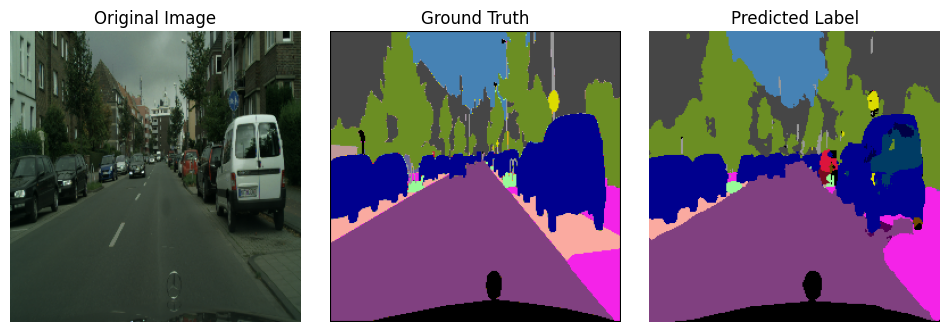

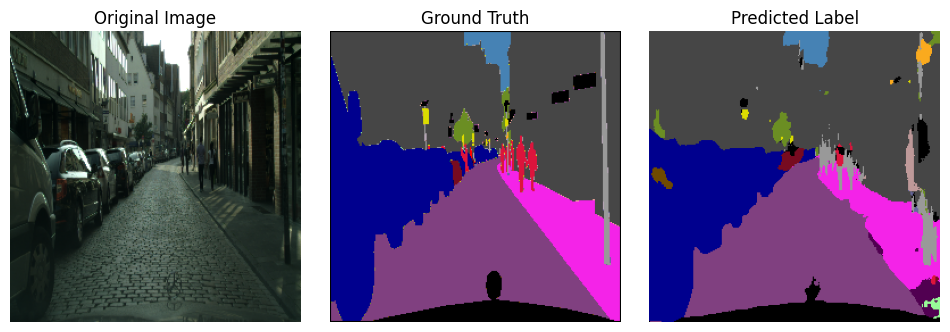

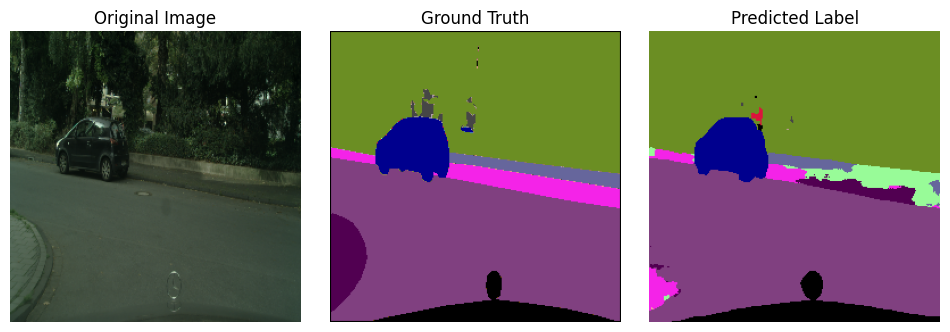

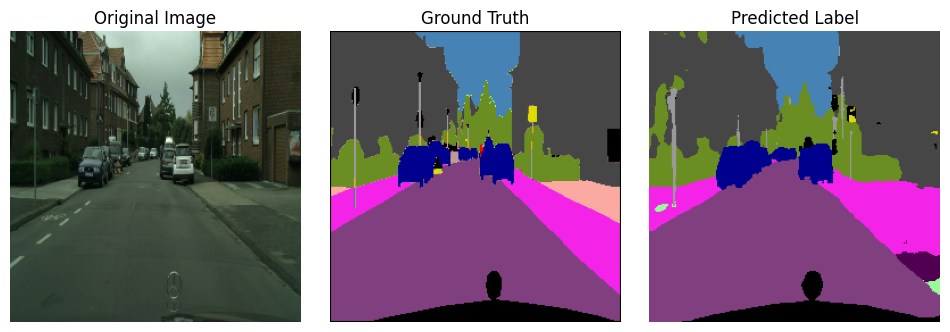

In [20]:
num = 4  # Number of images to display

for idx, (img, label) in enumerate(val_ds.take(1)):
    pred_label = model.predict(img)
    pred_label = tf.argmax(pred_label, axis=-1)
    pred_label = pred_label[..., tf.newaxis]
    
    for i in range(num):
        # Create a figure for each row
        plt.figure(figsize=(12, 4))  # Adjust width and height to control spacing
        plt.subplot(1, 3, 1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(img[i]))
        plt.title("Original Image")
        plt.axis("off")
        
        # Apply color map to the ground truth
        gt_colored = apply_color_map(label[i].numpy())
        plt.subplot(1, 3, 2)
        plt.imshow(gt_colored)
        plt.title("Ground Truth")
        plt.axis("off")
        
        # Apply color map to the predicted label
        pred_label_colored = apply_color_map(pred_label[i].numpy())
        plt.subplot(1, 3, 3)
        plt.imshow(pred_label_colored)
        plt.title("Predicted Label")
        plt.axis("off")
        
        # Adjust spacing
        plt.subplots_adjust(wspace=0.1, hspace=0)  # Reduce space between columns
        
        # Save the figure
        output_path = os.path.join("/kaggle/working/", f"image_{idx}_{i}.png")
        plt.savefig(output_path, bbox_inches="tight", dpi=300)
        #plt.close()  # Close the figure to save memory

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


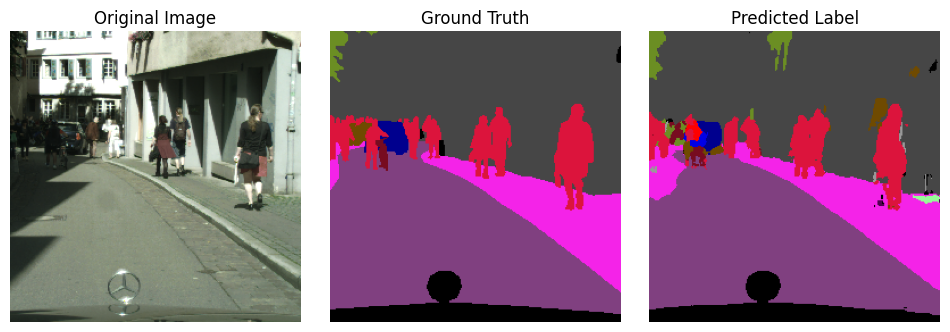

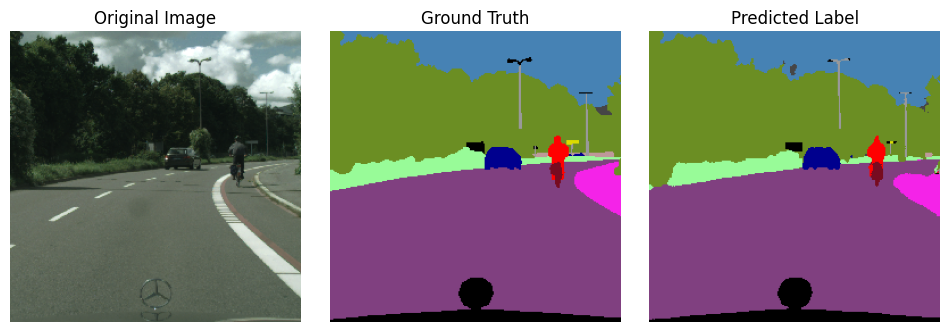

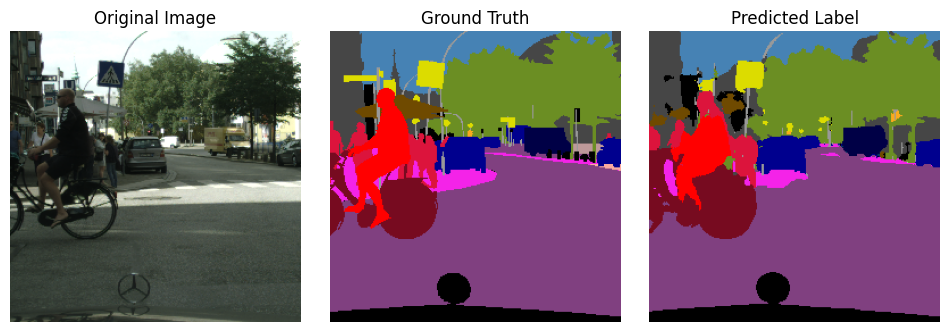

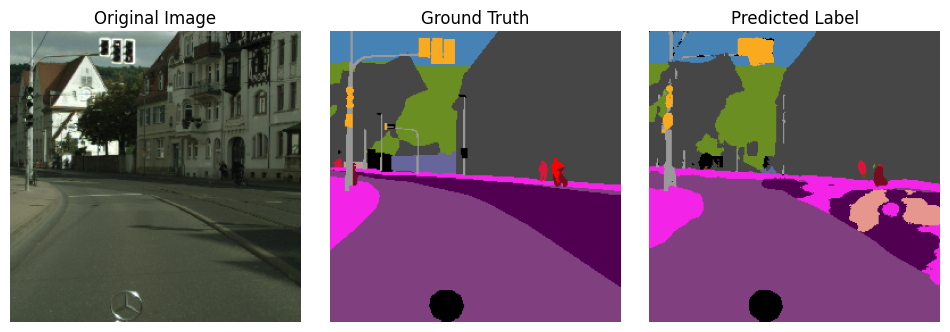

In [21]:
num = 4  # Number of images to display

for idx, (img, label) in enumerate(train_ds.take(1)):
    pred_label = model.predict(img)
    pred_label = tf.argmax(pred_label, axis=-1)
    pred_label = pred_label[..., tf.newaxis]
    
    for i in range(num):
        # Create a figure for each row
        plt.figure(figsize=(12, 4))  # Adjust width and height to control spacing
        plt.subplot(1, 3, 1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(img[i]))
        plt.title("Original Image")
        plt.axis("off")
        
        # Apply color map to the ground truth
        gt_colored = apply_color_map(label[i].numpy())
        plt.subplot(1, 3, 2)
        plt.imshow(gt_colored)
        plt.title("Ground Truth")
        plt.axis("off")
        
        # Apply color map to the predicted label
        pred_label_colored = apply_color_map(pred_label[i].numpy())
        plt.subplot(1, 3, 3)
        plt.imshow(pred_label_colored)
        plt.title("Predicted Label")
        plt.axis("off")
        
        # Adjust spacing
        plt.subplots_adjust(wspace=0.1, hspace=0)  # Reduce space between columns
        
        # Save the figure
        output_path = os.path.join("/kaggle/working/", f"image_{idx}_{i}.png")
        plt.savefig(output_path, bbox_inches="tight", dpi=300)
        #plt.close()  # Close the figure to save memory

# 2. Using Pre-trained Models

In [2]:
!pip install git+https://github.com/JanMarcelKezmann/TensorFlow-Advanced-Segmentation-Models.git

  Cloning https://github.com/JanMarcelKezmann/TensorFlow-Advanced-Segmentation-Models.git to /tmp/pip-req-build-3raph4qf
  Running command git clone --filter=blob:none --quiet https://github.com/JanMarcelKezmann/TensorFlow-Advanced-Segmentation-Models.git /tmp/pip-req-build-3raph4qf
  Resolved https://github.com/JanMarcelKezmann/TensorFlow-Advanced-Segmentation-Models.git to commit 3714839ee49759b26e2b0ae3d3a0aa37b00df962
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow_advanced_segmentation_models: filename=tensorflow_advanced_segmentation_models-0.4.10-py3-none-any.whl size=70079 sha256=37a6f26a37e6e492d940617e482e33dbef50b7fa1051a8a270e938ba377fe4f5
  Stored in directory: /tmp/pip-ephem-wheel-cache-nkxx6tqr/wheels/81/31/ae/80a6d6e86cebbc1f084947259d621128bf26c78448511b1461
Successfully built tensorflow_advanced_segmentation_models


In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_advanced_segmentation_models as tasm

In [4]:
def cityscapes_data_generator(image_dir, label_dir, input_shape=(256, 256), batch_size=16):
    cities = os.listdir(image_dir)
    while True:  # Infinite loop for training
        images = []
        labels = []
        for city in cities:
            city_img_path = os.path.join(image_dir, city)
            city_label_path = os.path.join(label_dir, city)

            if os.path.isdir(city_img_path):
                for filename in os.listdir(city_img_path):
                    img_path = os.path.join(city_img_path, filename)
                    label_filename = filename.replace("_leftImg8bit.png", "_gtFine_labelIds.png")
                    label_path = os.path.join(city_label_path, label_filename)

                    # Load and preprocess the image
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, input_shape)
                    img = img / 255.0  # Normalize

                    # Load and preprocess the label
                    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
                    label = cv2.resize(label, input_shape, interpolation=cv2.INTER_NEAREST)
                    label[label == 255] = -1  # Mask ignore regions
                    
                    images.append(img)
                    labels.append(label)

                    # Yield a batch when it's full
                    if len(images) == batch_size:
                        images = np.array(images, dtype=np.float32)
                        labels = np.array(labels, dtype=np.int32)
                        labels = tf.keras.utils.to_categorical(labels, num_classes=34)  # One-hot encoding
                        yield tf.convert_to_tensor(images), tf.convert_to_tensor(labels, tf.float32)
                        images, labels = [], []  # Reset for next batch

In [49]:
from tensorflow.keras.utils import Sequence

class CityscapesDataGenerator(Sequence):
    def __init__(self, image_dir, label_dir, input_shape=(256, 256), batch_size=16, **kwargs):
        super().__init__(**kwargs)
        self.image_paths = []  # Collect all image paths
        self.label_paths = []  # Collect all label paths
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.num_classes = 34
        
        cities = os.listdir(image_dir)
        for city in cities:
            city_img_path = os.path.join(image_dir, city)
            city_label_path = os.path.join(label_dir, city)
            if os.path.isdir(city_img_path):
                for filename in os.listdir(city_img_path):
                    self.image_paths.append(os.path.join(city_img_path, filename))
                    label_filename = filename.replace("_leftImg8bit.png", "_gtFine_labelIds.png")
                    self.label_paths.append(os.path.join(city_label_path, label_filename))

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_images = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.label_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        images, labels = [], []
        for img_path, label_path in zip(batch_images, batch_labels):
            img = cv2.imread(img_path)
            img = cv2.resize(img, self.input_shape)
            img = img / 255.0

            label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
            label = cv2.resize(label, self.input_shape, interpolation=cv2.INTER_NEAREST)
            label[label == 255] = -1
            
            images.append(img)
            labels.append(label)
        
        images = np.array(images, dtype=np.float32)
        labels = np.array(labels, dtype=np.int32)
        labels = tf.keras.utils.to_categorical(labels, num_classes=self.num_classes)
        
        return tf.convert_to_tensor(images), tf.convert_to_tensor(labels, tf.float32)


In [50]:
# Paths to images and labels
train_image_dir = "/kaggle/input/cityscapes/Cityspaces/images/train"
train_label_dir = "/kaggle/input/cityscapes/Cityspaces/gtFine/train"

val_image_dir = "/kaggle/input/cityscapes/Cityspaces/images/val"
val_label_dir = "/kaggle/input/cityscapes/Cityspaces/gtFine/val"

test_image_dir = "/kaggle/input/d/kavithak1388/cityscapes/Cityscape/leftImg8bit/test"
test_label_dir = "/kaggle/input/d/kavithak1388/cityscapes/Cityscape/gtFine/test"

# Load and preprocess data
#train_images, train_labels = load_cityscapes_images(train_image_dir, train_label_dir)
#val_images, val_labels = load_cityscapes_images(val_image_dir, val_label_dir)

In [51]:
BATCH_SIZE = 8
train_generator = CityscapesDataGenerator(train_image_dir, train_label_dir, batch_size=BATCH_SIZE)
val_generator = CityscapesDataGenerator(val_image_dir, val_label_dir, batch_size=BATCH_SIZE)
#test_generator = cityscapes_data_generator(test_image_dir, test_label_dir, batch_size=batch_size)

In [52]:
BACKBONE_NAME = "efficientnetb3"
WEIGHTS = "imagenet"
HEIGHT = 256
WIDTH = 256

In [53]:
base_model, layers, layer_names = tasm.create_base_model(name=BACKBONE_NAME, weights=WEIGHTS, height=HEIGHT, width=WIDTH, include_top=False, pooling=None)

BACKBONE_TRAINABLE = False
model = tasm.DANet(n_classes=34, base_model=base_model, output_layers=layers, backbone_trainable=BACKBONE_TRAINABLE)
     

In [54]:
opt = tf.keras.optimizers.SGD(learning_rate=0.2, momentum=0.9)
metrics = [tasm.metrics.IOUScore(threshold=0.5)]
#categorical_focal_dice_loss = tasm.losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0)
model.compile(
    optimizer=opt,
    loss=tasm.losses.CategoricalFocalLoss,
    metrics=metrics,
)
model.run_eagerly = True

callbacks = [
            #  tf.keras.callbacks.ModelCheckpoint("DeepLabV3plus.ckpt", verbose=1, save_weights_only=True, save_best_only=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor="iou_score", factor=0.2, patience=6, verbose=1, mode="max"),
             tf.keras.callbacks.EarlyStopping(monitor="iou_score", patience=16, mode="max", verbose=1, restore_best_weights=True)
]

In [56]:
#num_train_images = count_total_images(train_image_dir)
#steps_per_epoch = num_train_images // BATCH_SIZE

history = model.fit(
    train_generator,
    batch_size=BATCH_SIZE,
    epochs=10,
    validation_data=val_generator,
    #steps_per_epoch=steps_per_epoch
)


/tmp/ipykernel_23/2659619898.py:37: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  label[label == 255] = -1


Epoch 1/10
371/371 ━━━━━━━━━━━━━━━━━━━━ 503s 1s/step - iou_score: 0.4962 - loss: 0.0164 - val_iou_score: 0.5016 - val_loss: 0.0117
Epoch 2/10
371/371 ━━━━━━━━━━━━━━━━━━━━ 493s 1s/step - iou_score: 0.5143 - loss: 0.0090 - val_iou_score: 0.4967 - val_loss: 0.0124
Epoch 3/10
371/371 ━━━━━━━━━━━━━━━━━━━━ 491s 1s/step - iou_score: 0.5227 - loss: 0.0080 - val_iou_score: 0.5069 - val_loss: 0.0118
Epoch 4/10
371/371 ━━━━━━━━━━━━━━━━━━━━ 488s 1s/step - iou_score: 0.5264 - loss: 0.0075 - val_iou_score: 0.5096 - val_loss: 0.0135
Epoch 5/10
371/371 ━━━━━━━━━━━━━━━━━━━━ 487s 1s/step - iou_score: 0.5284 - loss: 0.0071 - val_iou_score: 0.4991 - val_loss: 0.0162
Epoch 6/10
371/371 ━━━━━━━━━━━━━━━━━━━━ 472s 1s/step - iou_score: 0.5348 - loss: 0.0070 - val_iou_score: 0.5019 - val_loss: 0.0082
Epoch 7/10
371/371 ━━━━━━━━━━━━━━━━━━━━ 459s 1s/step - iou_score: 0.5384 - loss: 0.0068 - val_iou_score: 0.5077 - val_loss: 0.0078
Epoch 8/10
371/371 ━━━━━━━━━━━━━━━━━━━━ 459s 1s/step - iou_score: 0.5433 - loss: 0.

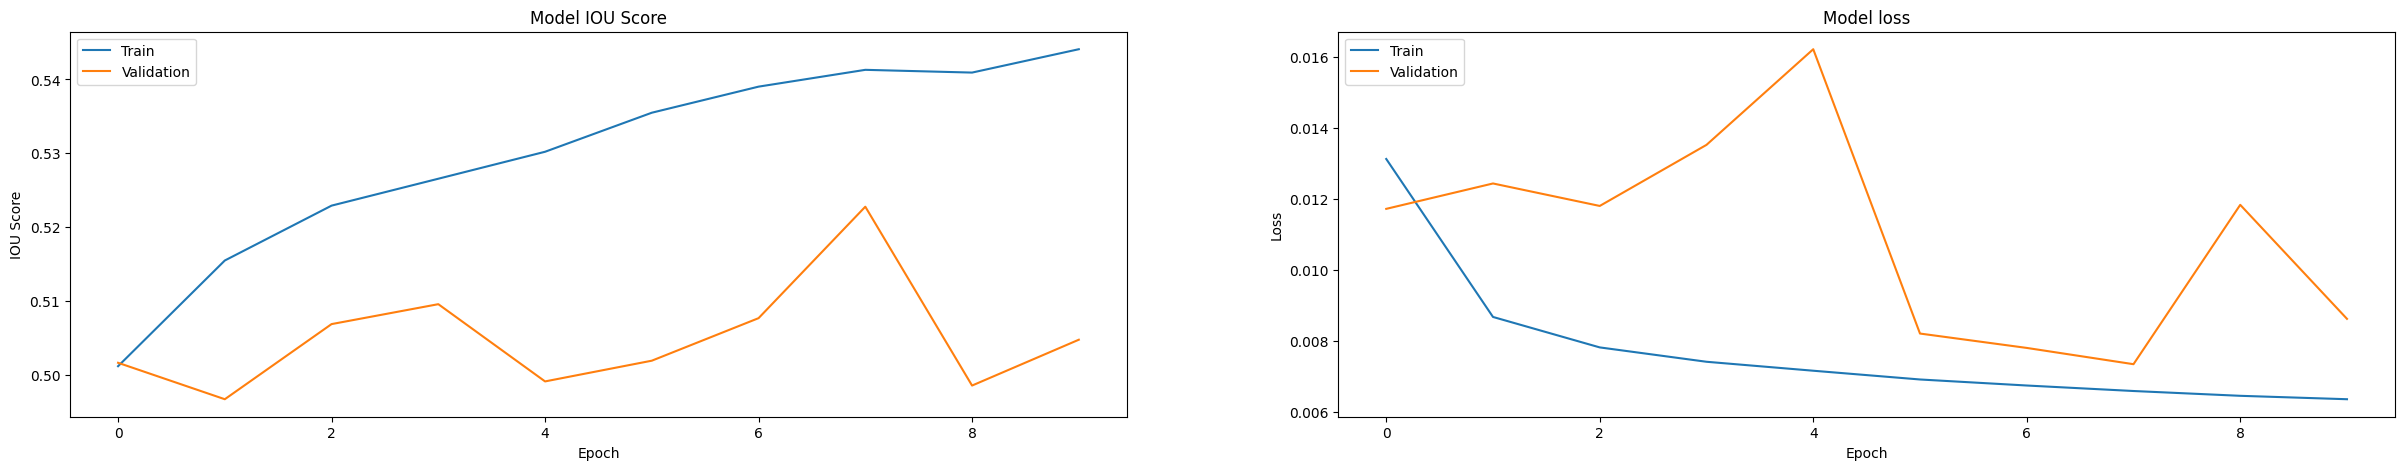

In [65]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model IOU Score')
plt.ylabel('IOU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
output_path = os.path.join("/kaggle/working/pre-trainedMLossandIOU.png")
plt.savefig(output_path, bbox_inches="tight", dpi=300)
plt.show()